### ISYE-6740 HW #1

In [1]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import time
from scipy.sparse import csc_matrix
import random

#### Question 1.6 Conceptual Question

In [2]:
L = np.array(
    [
        [1, 0, 0, 0, -1],
        [0, 1, 0, 0, -1],
        [0, 0, 1, 0, -1],
        [0, 0, 0, 0, 0],
        [-1, -1, -1, 0, 3],
    ]
)

eigvals, eigvecs = np.linalg.eig(L)

np.round(eigvals, 0).reshape(-1, 1), np.round(eigvecs, 0)

(array([[ 4.],
        [-0.],
        [ 1.],
        [ 1.],
        [ 0.]]),
 array([[ 0.,  1., -1., -0.,  0.],
        [ 0.,  0.,  0.,  1.,  0.],
        [ 0.,  1.,  0., -1.,  0.],
        [ 0.,  0.,  0.,  0.,  1.],
        [-1.,  0.,  0.,  0.,  0.]]))

#### Question 3 K-means Clustering

#### Part 1

In [3]:
# The code is modified based on https://towardsdatascience.com/clear-and-visual-explanation-of-the-k-means-algorithm-applied-to-image-compression-b7fdc547e410
def init_centroids(image, num_clusters):
    dimensions = image.shape

    if 0 < image[0, 0, 0] < 1:
        image = image * 255

    H = dimensions[0]
    W = dimensions[1]
    centroids_init = np.empty((num_clusters, 3))

    for i in range(num_clusters):
        rand_row = np.random.randint(0, H)
        rand_col = np.random.randint(0, W)
        centroids_init[i] = image[rand_row, rand_col]

    return (centroids_init, image)

In [4]:
def update_centroids_l2(centroids_init, image, epsilon=10**-2):
    # Keep track of time
    start = time.time()
    # Keep track of iteration
    iter = 0
    # Reshape image data to 2D
    data = image.reshape(-1, 3)

    # Number of data point
    m = data.shape[0]
    # Initialize change to centroids and update within the loop
    change = centroids_init

    while np.linalg.norm(change) > epsilon:
        # Adopted and modified based on the demo code, kmeans_digit, provided in the class for computing l2 norm
        # Norm squared of centroids
        c2 = np.sum(np.pow(centroids_init, 2), axis=1, keepdims=True)
        # Compute 2*x^i*c^j - (c^j)^2 and solve for the maximum
        d = 2 * np.dot(data, centroids_init.T) - c2.T
        clusters = np.argmax(d, axis=1)
        # Create sparse assignment matrix
        P = csc_matrix(
            (np.ones(m), (np.arange(0, m, 1), clusters)),
            shape=(m, centroids_init.shape[0]),
        )
        count = np.array(P.sum(axis=0)).reshape(-1)

        # Find empty clusters
        empty_cluster = np.where(count == 0)[0]
        # If there is any empty_cluster, remove from centroids_init and re-run all the computation code
        if len(empty_cluster) > 0:
            centroids_init = np.delete(centroids_init, empty_cluster, axis=0)

            # Adopted and modified the demo code provided in the class for computing l2 norm
            c2 = np.sum(np.pow(centroids_init, 2), axis=1, keepdims=True)
            d = 2 * np.dot(data, centroids_init.T) - c2.T
            clusters = np.argmax(d, axis=1)
            P = csc_matrix(
                (np.ones(m), (np.arange(0, m, 1), clusters)),
                shape=(m, centroids_init.shape[0]),
            )
            count = np.array(P.sum(axis=0)).reshape(-1)

        c = ((P.T @ data).T / count).T
        change = c - centroids_init
        centroids_init = c
        iter += 1

    end = time.time()
    print(
        f"When cluster k = {centroids_init.shape[0]}, it takes {iter} iterations and {end - start:.2f} seconds to converge"
    )
    # Getting back the 3d matrix (row, col, rgb(3)). Adapted code below from https://www.geeksforgeeks.org/image-compression-using-k-means-clustering/
    compressed_data = centroids_init[clusters]
    compressed_image = compressed_data.reshape(image.shape)

    # Compute total cost
    diff = data - centroids_init[clusters]
    total_cost = np.sum(np.pow(diff, 2))

    return (compressed_image, clusters.reshape(-1, 1), centroids_init, total_cost)

In [5]:
# The code below will take ~30m to run so commented out. Only kept in here for grader's reference.
# Find best seed
# seeds = np.arange(40)
# k = [3, 6, 12, 24, 48]

# total_cost = np.zeros((len(k), len(seeds)))

# for i in seeds:
#     np.random.seed(i)
#     for indx, k_val in enumerate(k):
#         centroid, football_image = init_centroids(football_image, k_val)
#         image_compressed, clusters, centroids, cost = update_centroids_l2(
#             centroid, football_image
#         )
#         total_cost[indx, i] = cost

# cost_by_seed = np.sum(total_cost, axis = 0)
# np.argmin(cost_by_seed)

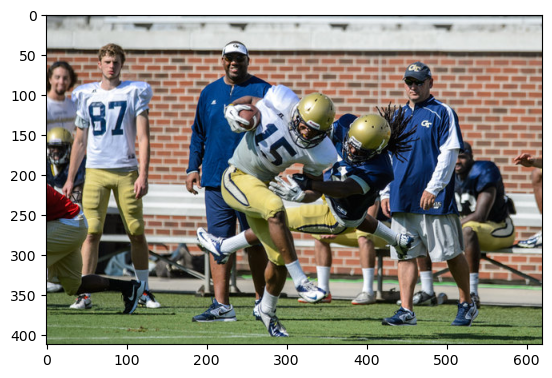

In [6]:
# Show original image
football_image = np.copy(mpimg.imread("football.bmp"))
plt.imshow(football_image)
plt.show()

When cluster k = 3, it takes 21 iterations and 0.44 seconds to converge
When cluster k = 6, it takes 29 iterations and 0.84 seconds to converge
When cluster k = 12, it takes 144 iterations and 6.32 seconds to converge
When cluster k = 24, it takes 133 iterations and 9.18 seconds to converge
When cluster k = 48, it takes 241 iterations and 29.38 seconds to converge


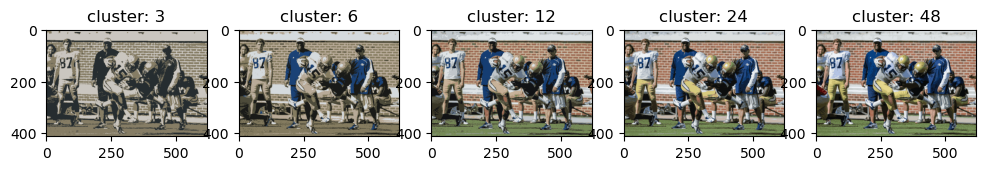

In [7]:
# Display compressed images
k = [3, 6, 12, 24, 48]

random.seed(14)
np.random.seed(14)

# Adapted the plotting code from https://engineeringfordatascience.com/posts/matplotlib_subplots/
fig, axs = plt.subplots(nrows=1, ncols=len(k), figsize=(12, 5))

for i in range(len(k)):
    centroid, football_image = init_centroids(football_image, k[i])
    image_compressed, clusters, centroids, cost = update_centroids_l2(
        centroid, football_image
    )
    axs[i].imshow(image_compressed.astype(np.uint8))
    axs[i].set_title("cluster: %s" % str(k[i]))

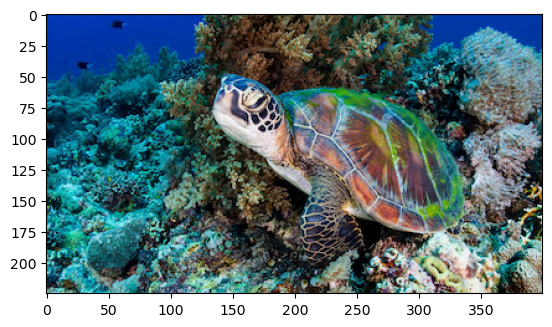

In [8]:
turtle_image = np.copy(mpimg.imread("sea-turtle-400x225.png"))
turtle_image_rgb = turtle_image[:, :, :3]

plt.imshow(turtle_image_rgb)
plt.show()

When cluster k = 3, it takes 15 iterations and 0.12 seconds to converge
When cluster k = 6, it takes 99 iterations and 1.08 seconds to converge
When cluster k = 12, it takes 91 iterations and 1.48 seconds to converge
When cluster k = 24, it takes 279 iterations and 7.35 seconds to converge
When cluster k = 47, it takes 389 iterations and 17.97 seconds to converge


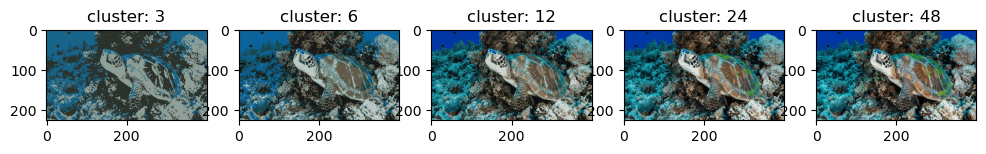

In [17]:
# Adapted the plotting code from https://engineeringfordatascience.com/posts/matplotlib_subplots/
fig, axs = plt.subplots(nrows=1, ncols=len(k), figsize=(12, 5))

random.seed(14)
np.random.seed(14)

for i in range(len(k)):
    centroid, turtle_image = init_centroids(turtle_image_rgb, k[i])
    image_compressed, clusters, centroids, cost = update_centroids_l2(
        centroid, turtle_image
    )
    axs[i].imshow(image_compressed.astype(np.uint8))
    axs[i].set_title("cluster: %s" % str(k[i]))

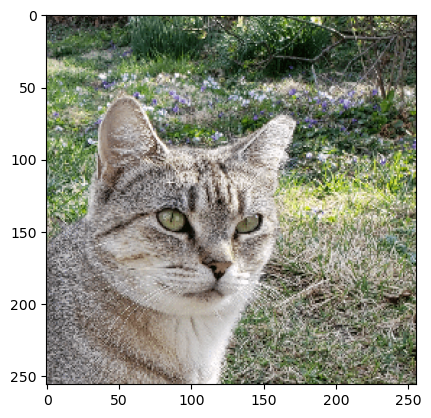

In [10]:
cat_image = np.copy(mpimg.imread("cat_png.png"))
cat_image_rgb = cat_image[:, :, :3]

plt.imshow(cat_image_rgb)
plt.show()

When cluster k = 3, it takes 12 iterations and 0.06 seconds to converge
When cluster k = 6, it takes 20 iterations and 0.13 seconds to converge
When cluster k = 9, it takes 13 iterations and 0.12 seconds to converge
When cluster k = 21, it takes 9 iterations and 0.16 seconds to converge
When cluster k = 44, it takes 8 iterations and 0.26 seconds to converge


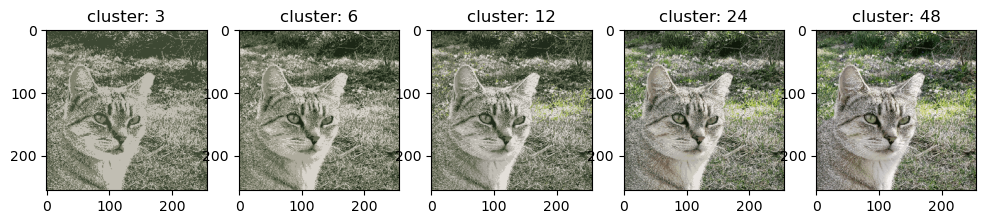

In [18]:
# Adapted the plotting code from https://engineeringfordatascience.com/posts/matplotlib_subplots/
fig, axs = plt.subplots(nrows=1, ncols=len(k), figsize=(12, 5))

random.seed(14)
np.random.seed(14)

for i in range(len(k)):
    centroid, cat_image = init_centroids(cat_image_rgb, k[i])
    image_compressed, clusters, centroids, cost = update_centroids_l2(
        centroid, cat_image
    )
    axs[i].imshow(image_compressed.astype(np.uint8))
    axs[i].set_title("cluster: %s" % str(k[i]))

#### Part 2

In [12]:
def update_centroids_l1(centroids_init, image, epsilon=10**-2):
    # Keep track of time
    start = time.time()
    # Keep track of iteration
    iter = 0
    # Reshape image data to 2D
    data = image.reshape(-1, 3)

    # Number of data point
    m = data.shape[0]
    # Initialize change to centroids and update within the loop
    change = centroids_init

    while np.linalg.norm(change) > epsilon:

        # Create a matrix to store l1 norm by centroid for all data point
        diff_mat = np.zeros((data.shape[0], centroids_init.shape[0]))
        for i in range(len(centroids_init)):
            # Sum absolute difference by color channel
            diff_mat[:, i] = np.sum(np.abs(data - centroids_init[i]), axis=1)

        clusters = np.argmin(diff_mat, axis=1)
        # Create sparse assignment matrix
        P = csc_matrix(
            (np.ones(m), (np.arange(0, m, 1), clusters)),
            shape=(m, centroids_init.shape[0]),
        )
        count = np.array(P.sum(axis=0)).reshape(-1)

        # Find empty clusters
        empty_cluster = np.where(count == 0)[0]
        # If there is any empty_cluster, remove from centroids_init and re-run all the computation code
        if len(empty_cluster) > 0:

            # Modified the np.delete function based on the use case found at https://note.nkmk.me/en/python-numpy-delete/#:~:text=In%20NumPy%2C%20the%20np.,from%20an%20array%20(%20ndarray%20).&text=Users%20must%20specify%20the%20target,column%20numbers)%20to%20be%20deleted.
            centroids_init = np.delete(centroids_init, empty_cluster, axis=0)

            # Re-run the same code as above
            diff_mat = np.zeros((data.shape[0], centroids_init.shape[0]))
            for i in range(len(centroids_init)):
                # Sum absolute difference by color channel
                diff_mat[:, i] = np.sum(np.abs(data - centroids_init[i]), axis=1)

            clusters = np.argmin(diff_mat, axis=1)
            P = csc_matrix(
                (np.ones(m), (np.arange(0, m, 1), clusters)),
                shape=(m, centroids_init.shape[0]),
            )
            count = np.array(P.sum(axis=0)).reshape(-1)

        c = ((P.T @ data).T / count).T
        change = c - centroids_init
        centroids_init = c
        iter += 1

    end = time.time()
    print(
        f"When cluster k = {centroids_init.shape[0]}, it takes {iter} iterations and {end - start:.2f} seconds to converge"
    )

    # Create compressed image
    compressed_data = centroids_init[clusters]
    compressed_image = compressed_data.reshape(image.shape)

    # Compute total cost
    diff = data - centroids_init[clusters]
    total_cost = np.sum(np.abs(diff))

    return (compressed_image, clusters.reshape(-1, 1), centroids_init, total_cost)

Repeat the same process as part 1 below for only football.bmp image

When cluster k = 3, it takes 13 iterations and 0.53 seconds to converge
When cluster k = 6, it takes 61 iterations and 4.70 seconds to converge
When cluster k = 12, it takes 48 iterations and 7.39 seconds to converge
When cluster k = 24, it takes 61 iterations and 17.15 seconds to converge
When cluster k = 48, it takes 82 iterations and 46.78 seconds to converge


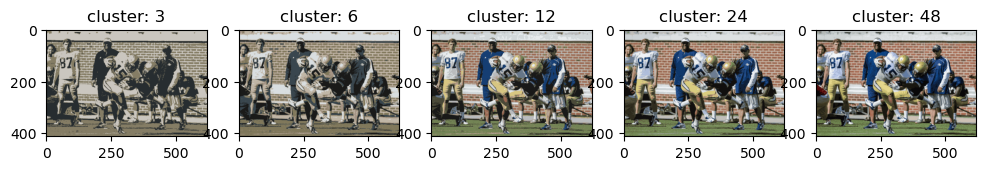

In [19]:
# Adapted the plotting code from https://engineeringfordatascience.com/posts/matplotlib_subplots/
fig, axs = plt.subplots(nrows=1, ncols=len(k), figsize=(12, 5))

random.seed(14)
np.random.seed(14)

for i in range(len(k)):
    centroid, turtle_image = init_centroids(football_image, k[i])
    image_compressed, clusters, centroids, cost = update_centroids_l1(
        centroid, football_image
    )
    axs[i].imshow(image_compressed.astype(np.uint8))
    axs[i].set_title("cluster: %s" % str(k[i]))

#### Part 3

When cluster k = 3, it takes 21 iterations and 0.41 seconds to converge
When cluster k = 6, it takes 29 iterations and 0.77 seconds to converge
When cluster k = 12, it takes 144 iterations and 5.99 seconds to converge
When cluster k = 24, it takes 133 iterations and 8.80 seconds to converge
When cluster k = 48, it takes 241 iterations and 28.12 seconds to converge


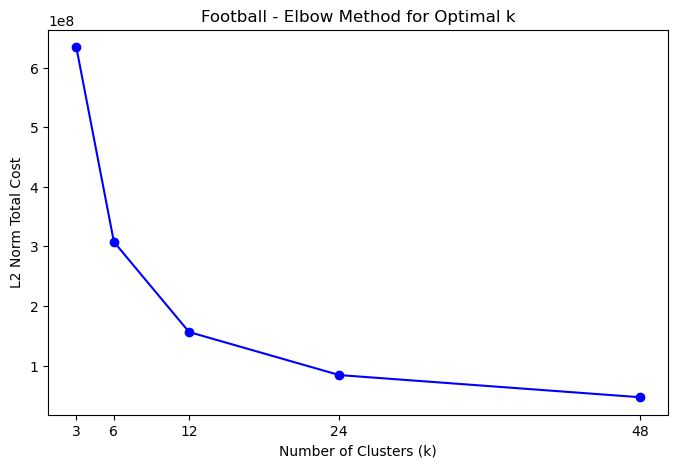

In [14]:
# Football image - check for best k
k = [3, 6, 12, 24, 48]
actual_k = np.zeros(len(k))
football_total_cost = np.zeros(len(k))

np.random.seed(14)

for i in range(len(k)):
    centroid, football_image = init_centroids(football_image, k[i])
    _, clusters, centroids, cost = update_centroids_l2(centroid, football_image)
    football_total_cost[i] = cost
    actual_k[i] = len(centroids)


plt.figure(figsize=(8, 5))
plt.plot(actual_k, football_total_cost, "bo-")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("L2 Norm Total Cost")
plt.xticks(actual_k)
plt.title("Football - Elbow Method for Optimal k")
plt.show()

When cluster k = 3, it takes 15 iterations and 0.11 seconds to converge
When cluster k = 6, it takes 99 iterations and 0.87 seconds to converge
When cluster k = 12, it takes 91 iterations and 1.26 seconds to converge
When cluster k = 24, it takes 279 iterations and 6.38 seconds to converge
When cluster k = 47, it takes 389 iterations and 16.92 seconds to converge


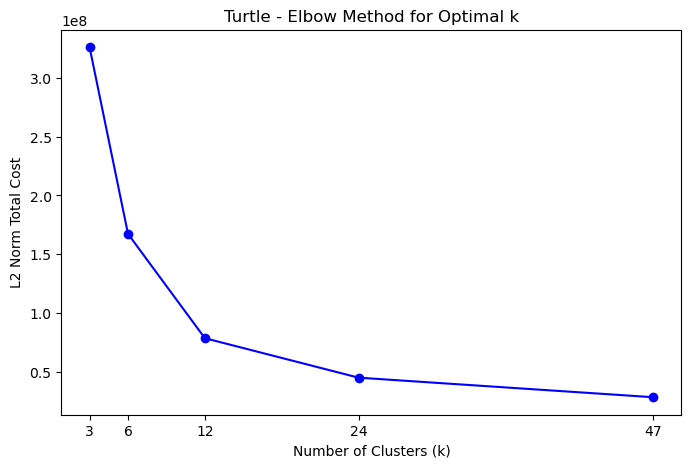

In [15]:
# Turtle image - check for best k
k = [3, 6, 12, 24, 48]
actual_k = np.zeros(len(k))
turtle_total_cost = np.zeros(len(k))

np.random.seed(14)

for i in range(len(k)):
    centroid, turtle_image = init_centroids(turtle_image_rgb, k[i])
    _, clusters, centroids, cost = update_centroids_l2(centroid, turtle_image)
    turtle_total_cost[i] = cost
    actual_k[i] = len(centroids)


plt.figure(figsize=(8, 5))
plt.plot(actual_k, turtle_total_cost, "bo-")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("L2 Norm Total Cost")
plt.xticks(actual_k)
plt.title("Turtle - Elbow Method for Optimal k")
plt.show()

When cluster k = 3, it takes 12 iterations and 0.07 seconds to converge
When cluster k = 6, it takes 20 iterations and 0.12 seconds to converge
When cluster k = 9, it takes 13 iterations and 0.12 seconds to converge
When cluster k = 21, it takes 9 iterations and 0.15 seconds to converge
When cluster k = 44, it takes 8 iterations and 0.26 seconds to converge


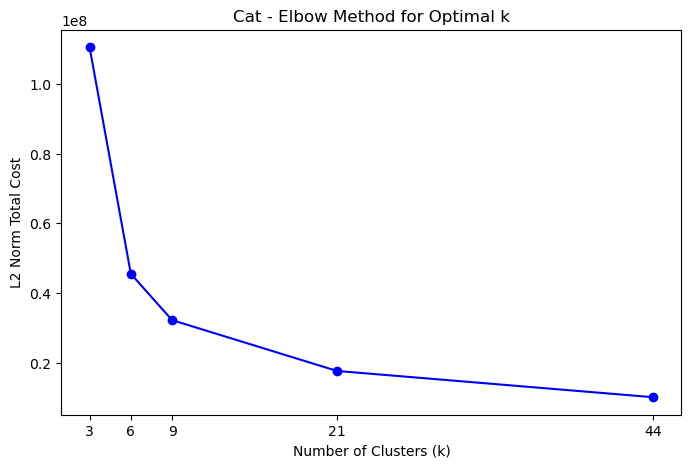

In [16]:
# Cat image - check for best k
k = [3, 6, 12, 24, 48]
actual_k = np.zeros(len(k))
cat_total_cost = np.zeros(len(k))

np.random.seed(14)

for i in range(len(k)):
    centroid, cat_image = init_centroids(cat_image_rgb, k[i])
    _, clusters, centroids, cost = update_centroids_l2(centroid, cat_image)
    cat_total_cost[i] = cost
    actual_k[i] = len(centroids)


plt.figure(figsize=(8, 5))
plt.plot(actual_k, cat_total_cost, "bo-")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("L2 Norm Total Cost")
plt.xticks(actual_k)
plt.title("Cat - Elbow Method for Optimal k")
plt.show()